In [ ]:
import os
from PIL import Image, ExifTags
from pycocotools.coco import COCO
# from matplotlib.patches import Polygon, Rectangle
# from matplotlib.collections import PatchCollection
# import colorsys
# import random
# import pylab

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import shutil

import cv2

# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils

In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
if not os.path.isfile('./TACO.zip'):
  %cp /gdrive/MyDrive/TACO.zip /content/
  !unzip -qq TACO.zip

Mounted at /gdrive


In [ ]:
!wget https://github.com/pedropro/TACO/raw/master/data/annotations.json

--2023-04-16 04:30:00--  https://github.com/pedropro/TACO/raw/master/data/annotations.json
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations.json [following]
--2023-04-16 04:30:01--  https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3022022 (2.9M) [text/plain]
Saving to: ‘annotations.json’

annotations.json    100%[===================>]   2.88M  --.-KB/s    in 0.03s   

2023-04-16 04:30:01 (109 MB/s) - ‘annotations.json’ saved [3022022/3022022]



In [ ]:
coco = COCO('./annotations.json')

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


## get positive images

In [ ]:
!rm -rf /content/img_cut
!mkdir -p /content/img_cut/{img,lbl}

for img_id in tqdm(range(1500)):
  annotation_ids = coco.getAnnIds(img_id)
  if len(annotation_ids) == 0:
    continue

  img_info = coco.loadImgs(img_id)[0]
  #print(img_info)
  height = img_info['height']
  width = img_info['width']
  annotations = coco.loadAnns(annotation_ids)
  for i in annotations:
    image = cv2.imread('/content/TACO/'+str(img_id)+'.jpg')
    x,y,w,h = [int(j) for j in np.clip(i['bbox'],0,None)]
    cut = image[y:y+h,x:x+w]
    cv2.imwrite('/content/img_cut/img/'+str(img_id)+'_'+str(i['id'])+'.jpg',cut)
    np.savez_compressed('/content/img_cut/lbl/'+str(img_id)+'_'+str(i['id'])+'.npz',i)


100%|██████████| 1500/1500 [09:42<00:00,  2.57it/s]


In [ ]:
!cp -r img_cut /gdrive/MyDrive

## get negative images

In [ ]:
seg_size = []
for img_id in tqdm(range(1500)):
  annotation_ids = coco.getAnnIds(img_id)
  if len(annotation_ids) == 0:
    continue

  img_info = coco.loadImgs(img_id)[0]
  #print(img_info)
  height = img_info['height']
  width = img_info['width']
  annotations = coco.loadAnns(annotation_ids)
  for i in annotations:
    #image = cv2.imread('/content/TACO/'+str(img_id)+'.jpg')
    x,y,w,h = [int(j) for j in np.clip(i['bbox'],0,None)]
    seg_size.append([w,h])

100%|██████████| 1500/1500 [00:00<00:00, 12383.76it/s]


(array([3061.,  895.,  359.,  189.,  115.,   62.,   38.,   29.,   20.,
          16.]),
 array([0.00306373, 0.10272389, 0.20238405, 0.30204421, 0.40170437,
        0.50136453, 0.60102469, 0.70068485, 0.80034501, 0.90000517,
        0.99966533]),
 <BarContainer object of 10 artists>)

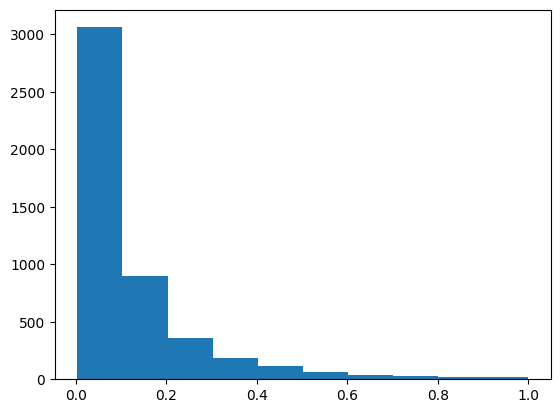

In [ ]:
plt.hist([i[2]/i[0] for i in seg_size])

<Axes: ylabel='Count'>

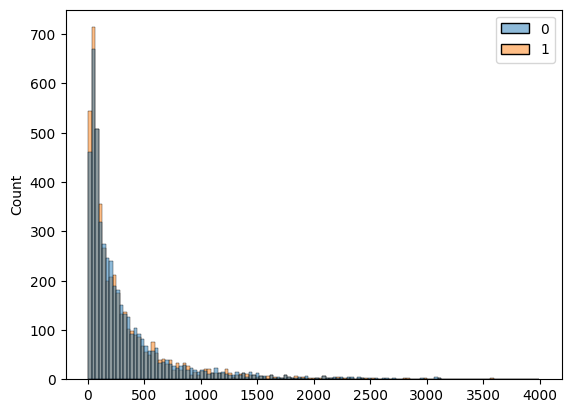

In [ ]:
sns.histplot(np.array(seg_size))